In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import cmocean
import xarray as xr
import xroms
import glob
import os
import datetime
import numpy as np
import dateutil
import dask

In [2]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster(dashboard_address=':8787')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39499,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:38857,Total threads: 8
Dashboard: http://127.0.0.1:42271/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:45359,


In [3]:
data_path = '/southern/rbarkan/data/SWC2km/OUTPUT/W_rivers/HIS/'
save_path = '/meddy/lwang/data/SWC2km_Wrivers_data/'
figure_dir = '/meddy/lwang/figures/model_validation/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
#ds_bz =xr.open_dataset('/meddy/lwang/data/SWC2km_Wrivers_data/sample_Argo_compare/z_yearly_avg_sample_bz_SWC2km_argo.nc')

In [4]:
filenames = sorted(glob.glob('/meddy/lwang/data/SWC2km_Wrivers_data/sample_Argo_compare/' + 'z_sample_bz_SWC2km.*.nc')) 
print('Number of files processed: %d' %len(filenames))

Number of files processed: 365


In [5]:
ds = xr.open_mfdataset(filenames, concat_dim='time', combine="nested")
ds

<xarray.Dataset> Size: 10GB
Dimensions:     (time: 365, depth: 57, eta_rho: 381, xi_rho: 320)
Coordinates:
  * depth       (depth) float32 228B -2.0 -5.0 -7.5 ... -900.0 -950.0 -1e+03
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    bz          (time, depth, eta_rho, xi_rho) float32 10GB dask.array<chunksize=(1, 57, 381, 320), meta=np.ndarray>
    ocean_time  (time) float64 3kB 5.233e+08 5.234e+08 ... 5.547e+08 5.548e+08

In [6]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])

In [7]:
ds_bz=ds.bz
ds_bz = ds_bz.assign_coords(time=dtime)
ds_bz

<xarray.DataArray 'bz' (time: 365, depth: 57, eta_rho: 381, xi_rho: 320)> Size: 10GB
dask.array<concatenate, shape=(365, 57, 381, 320), dtype=float32, chunksize=(1, 57, 381, 320), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 228B -2.0 -5.0 -7.5 -10.0 ... -900.0 -950.0 -1e+03
  * time     (time) datetime64[ns] 3kB 2016-07-31T23:21:32 ... 2017-07-30T23:...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  vertical gradient of buoyancy
    units:      second-2

In [8]:
ds_bz_summer1 = ds_bz.sel(time=slice("2016-07-31", "2016-09-30") )
ds_bz_summer2 = ds_bz.sel(time=slice("2017-05-01", "2017-7-31") )

ds_bz_summer = xr.concat([ds_bz_summer1, ds_bz_summer2], dim='time')
ds_bz_summer

<xarray.DataArray 'bz' (time: 153, depth: 57, eta_rho: 381, xi_rho: 320)> Size: 4GB
dask.array<concatenate, shape=(153, 57, 381, 320), dtype=float32, chunksize=(1, 57, 381, 320), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 228B -2.0 -5.0 -7.5 -10.0 ... -900.0 -950.0 -1e+03
  * time     (time) datetime64[ns] 1kB 2016-07-31T23:21:32 ... 2017-07-30T23:...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  vertical gradient of buoyancy
    units:      second-2

In [9]:
ds_bz_winter = ds_bz.sel(time=slice("2016-11-01", "2017-03-31") )
ds_bz_winter

<xarray.DataArray 'bz' (time: 151, depth: 57, eta_rho: 381, xi_rho: 320)> Size: 4GB
dask.array<getitem, shape=(151, 57, 381, 320), dtype=float32, chunksize=(1, 57, 381, 320), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 228B -2.0 -5.0 -7.5 -10.0 ... -900.0 -950.0 -1e+03
  * time     (time) datetime64[ns] 1kB 2016-11-01T23:21:32 ... 2017-03-31T23:...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  vertical gradient of buoyancy
    units:      second-2

In [10]:
ds_bz = ds_bz.where(ds_bz.compute()>0, drop=True)
ds_bz_summer = ds_bz_summer.where(ds_bz_summer.compute()>0, drop=True)
ds_bz_winter = ds_bz_winter.where(ds_bz_winter.compute()>0, drop=True)

In [11]:
ds_bz = np.sqrt(ds_bz)
ds_bz_summer = np.sqrt(ds_bz_summer)
ds_bz_winter = np.sqrt(ds_bz_winter)

In [12]:
avg_bz = ds_bz.mean(dim={'eta_rho','xi_rho'})
summer_bz = ds_bz_summer.mean(dim={'eta_rho','xi_rho'})
winter_bz = ds_bz_winter.mean(dim={'eta_rho','xi_rho'})

In [13]:
N_profile = avg_bz.mean(dim='time')
N_profile_summer = summer_bz.mean(dim='time')
N_profile_winter = winter_bz.mean(dim='time')

In [14]:
std_annual = avg_bz.std(dim='time')
std_summer = summer_bz.std(dim='time')
std_winter = winter_bz.std(dim='time')

In [11]:
ds_bz1 =xr.open_dataset('/meddy/lwang/data/SWC2km_Wrivers_data/sample_Argo_compare/z_yearly_avg_sample_bz_SWC2km_argo.nc')
N_profile1 = np.sqrt(ds_bz1.bz.mean(dim={'eta_rho','xi_rho'}))

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


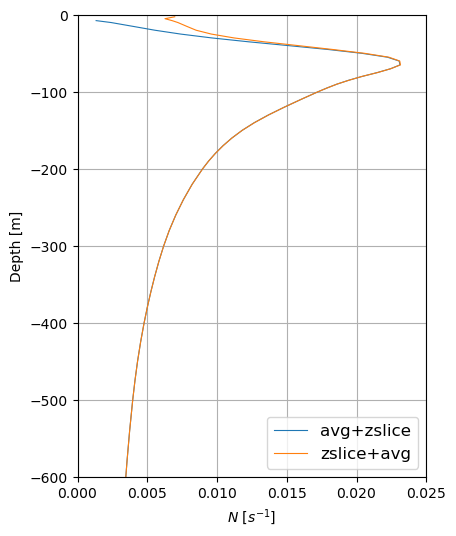

In [31]:
fig, ax = plt.subplots(1,1,figsize=(4.5,6.))
plt.plot(N_profile1, ds_bz1.depth, linewidth=0.8, label='avg+zslice')
plt.plot(N_profile, ds_bz.depth, linewidth=0.8, label='zslice+avg')
plt.xlabel(r'$N$' + ' ' + r'$[s^{-1}]$')
plt.ylabel('Depth [m]')
plt.xlim([0,0.025])
plt.ylim([-600,0])
plt.legend(loc='lower right',fontsize=12)
plt.grid()
#plt.savefig(figure_dir +'N_profile_zslice_avg.png', bbox_inches='tight')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 0.98 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 0.99 GiB.
T

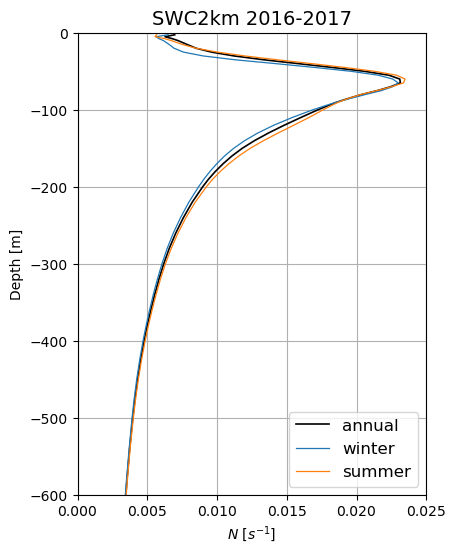

In [35]:
fig, ax = plt.subplots(1,1,figsize=(4.5,6.))
plt.plot(N_profile, ds_bz.depth, 'k', linewidth=1.2, label='annual')
plt.plot(N_profile_winter, ds_bz.depth, 'tab:blue', linewidth=0.9, label='winter')
plt.plot(N_profile_summer, ds_bz.depth, 'tab:orange', linewidth=0.9, label='summer')
plt.xlabel(r'$N$' + ' ' + r'$[s^{-1}]$')
plt.ylabel('Depth [m]')
plt.xlim([0,0.025])
plt.ylim([-600,0])
plt.legend(loc='lower right',fontsize=12)
plt.grid()
plt.title('SWC2km 2016-2017', fontsize=14)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 0.98 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 0.99 GiB.
T

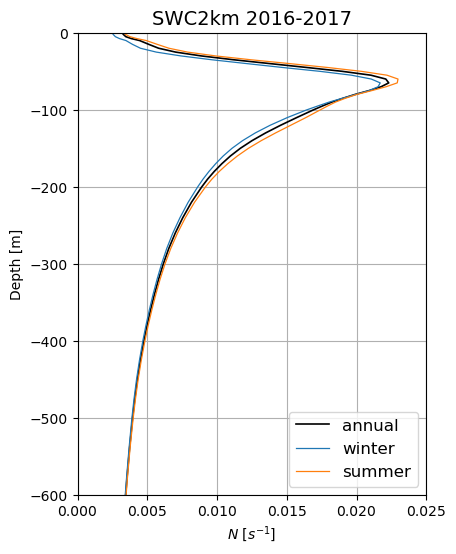

In [16]:
fig, ax = plt.subplots(1,1,figsize=(4.5,6.))
plt.plot(N_profile, ds_bz.depth, 'k', linewidth=1.2, label='annual')
plt.plot(N_profile_winter, ds_bz.depth, 'tab:blue', linewidth=0.9, label='winter')
plt.plot(N_profile_summer, ds_bz.depth, 'tab:orange', linewidth=0.9, label='summer')
plt.xlabel(r'$N$' + ' ' + r'$[s^{-1}]$')
plt.ylabel('Depth [m]')
plt.xlim([0,0.025])
plt.ylim([-600,0])
plt.legend(loc='lower right',fontsize=12)
plt.grid()
plt.title('SWC2km 2016-2017', fontsize=14)
plt.savefig(figure_dir +'N_profile.png', bbox_inches='tight')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 0.98 GiB.
T

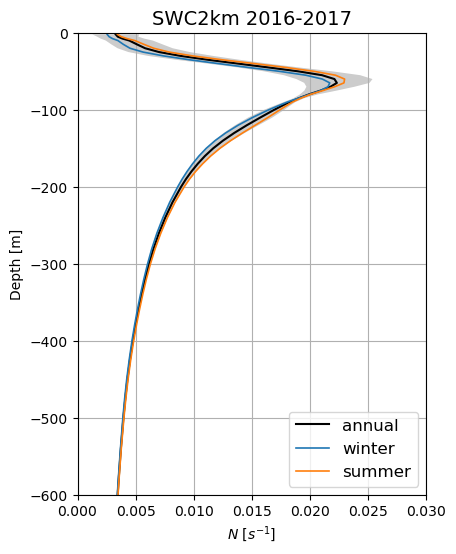

In [16]:
fig, ax = plt.subplots(1,1,figsize=(4.5,6.))
plt.plot(N_profile, ds_bz.depth, 'k', linewidth=1.5, label='annual')
plt.fill_betweenx(ds_bz.depth, N_profile-std_annual, N_profile+std_annual, edgecolor=None, facecolor='k', alpha=0.2)

plt.plot(N_profile_winter, ds_bz.depth, 'tab:blue', linewidth=1.2, label='winter')
#plt.fill_betweenx(ds_bz.depth, N_profile_winter-std_winter, N_profile_winter+std_winter, edgecolor=None, facecolor='tab:blue', alpha=0.2)

plt.plot(N_profile_summer, ds_bz.depth, 'tab:orange', linewidth=1.2, label='summer')
#plt.fill_betweenx(ds_bz.depth, N_profile_summer-std_summer, N_profile_summer+std_summer, edgecolor=None, facecolor='tab:orange', alpha=0.2)

plt.xlabel(r'$N$' + ' ' + r'$[s^{-1}]$')
plt.ylabel('Depth [m]')
plt.xlim([0,0.03])
plt.ylim([-600,0])
plt.legend(loc='lower right',fontsize=12)
plt.grid()
plt.title('SWC2km 2016-2017', fontsize=14)

plt.savefig(figure_dir +'N_profile.png', bbox_inches='tight')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 2.36 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 0.98 GiB.
T

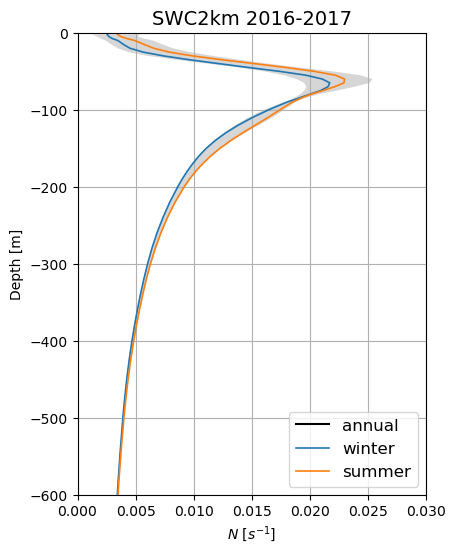

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4.5,6.))
plt.plot(N_profile/1e-2, ds_bz.depth, 'k', linewidth=1.5, label='annual')
plt.fill_betweenx(ds_bz.depth, N_profile-std_annual, N_profile+std_annual, edgecolor=None, facecolor='k', alpha=0.16)

plt.plot(N_profile_winter, ds_bz.depth, 'tab:blue', linewidth=1.2, label='winter')
#plt.fill_betweenx(ds_bz.depth, N_profile_winter-std_winter, N_profile_winter+std_winter, edgecolor=None, facecolor='tab:blue', alpha=0.2)

plt.plot(N_profile_summer, ds_bz.depth, 'tab:orange', linewidth=1.2, label='summer')
#plt.fill_betweenx(ds_bz.depth, N_profile_summer-std_summer, N_profile_summer+std_summer, edgecolor=None, facecolor='tab:orange', alpha=0.2)

plt.xlabel(r'$N$' + ' ' + r'$[s^{-1}]$')
plt.ylabel('Depth [m]')
plt.xlim([0,0.03])
plt.ylim([-600,0])
plt.legend(loc='lower right',fontsize=12)
plt.grid()
plt.title('SWC2km 2016-2017', fontsize=14)

plt.savefig(figure_dir +'N_profile.png', bbox_inches='tight', dpi=500)

In [4]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
mask=grd.mask_rho
grd

<xarray.Dataset> Size: 210MB
Dimensions:     (eta_rho: 1296, xi_rho: 1502, eta_v: 1295, xi_u: 1501)
Dimensions without coordinates: eta_rho, xi_rho, eta_v, xi_u
Data variables: (12/21)
    angle       (eta_rho, xi_rho) float64 16MB ...
    cent_lat    float64 8B ...
    f           (eta_rho, xi_rho) float64 16MB ...
    flip_xy     float64 8B ...
    h           (eta_rho, xi_rho) float64 16MB ...
    hraw        (eta_rho, xi_rho) float64 16MB ...
    ...          ...
    spherical   |S1 1B ...
    tapering    float64 8B ...
    tra_lat     float64 8B ...
    tra_lon     float64 8B ...
    wgt         (eta_rho, xi_rho) float64 16MB ...
    river_flux  (eta_rho, xi_rho) float32 8MB ...
Attributes:
    Title:     ROMS grid produced by Easy Grid
    Settings:  nx=1500 ny=1294 size_x=3000 size_y=2500 cent_lat=55 tapering=0...
    Date:      16-Apr-2024
    history:   Thu Nov 21 11:12:03 2024: ncks -x -v river_flux SWC2km_grd.nc ...
    NCO:       netCDF Operators version 4.9.2-alpha05 (Homepage = http://nco....

In [5]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])
np.min(lon), np.max(lon), np.min(lat), np.max(lat)

(97.66378677317915, 131.16136997796303, 1.4662102669404553, 26.3837638116976)

In [6]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])
lat_min, lat_max = 12, 18
lon_min, lon_max = 112, 117
index = np.argwhere( (lat>lat_min) & (lat<lat_max) & (lon>lon_min) & (lon<lon_max))

print('i:', np.min(index[:,1]), np.max(index[:,1]))
print('j:', np.min(index[:,0]), np.max(index[:,0]))

i0, i1 = np.min(index[:,1]), np.max(index[:,1])
j0, j1 = np.min(index[:,0]), np.max(index[:,0])

i: 661 980
j: 485 865


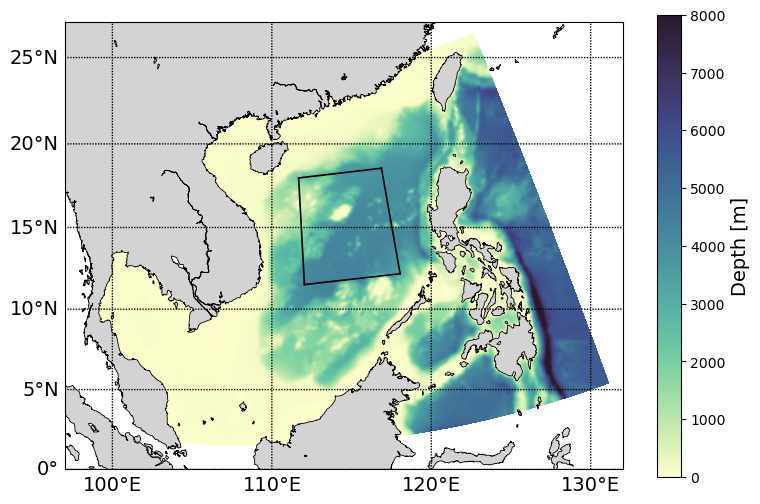

In [7]:
fig, ax = plt.subplots(1,1,figsize=(9.,6.))

m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
depth = grd.h.where(mask > 0)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)

xp_upperleft, yp_upperleft = m(lon[j0,i1],lat[j0,i1])
xp_upperright, yp_upperright = m(lon[j1,i1],lat[j1,i1])
xp_lowerleft, yp_lowerleft = m(lon[j0,i0],lat[j0,i0])
xp_lowerright, yp_lowerright = m(lon[j1,i0],lat[j1,i0])
plt.plot([xp_upperleft,xp_upperright],[yp_upperleft,yp_upperright],'k-',linewidth=1.2)
plt.plot([xp_upperleft,xp_lowerleft],[yp_upperleft,yp_lowerleft],'k-',linewidth=1.2)
plt.plot([xp_lowerleft,xp_lowerright],[yp_lowerleft,yp_lowerright],'k-',linewidth=1.2)
plt.plot([xp_upperright,xp_lowerright],[yp_upperright,yp_lowerright],'k-',linewidth=1.2)

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=14)

plt.savefig(figure_dir +'Bathymetry_with_Argo_data_region.png', bbox_inches='tight', dpi=300)

CPU times: user 2.57 s, sys: 161 ms, total: 2.73 s
Wall time: 2.62 s


Text(0, 0.5, 'hsmth [m]')

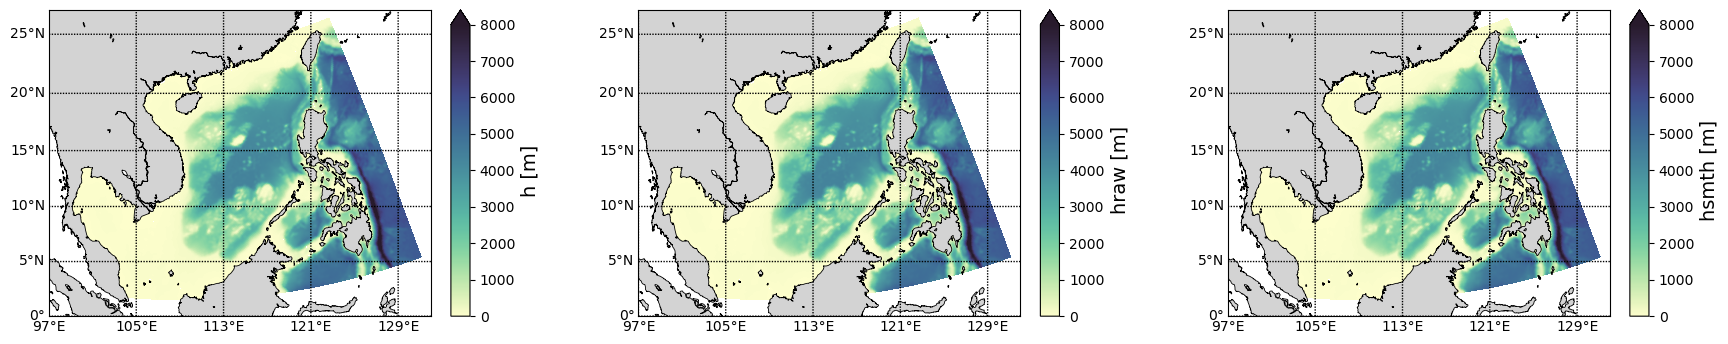

In [29]:
%%time
fig = plt.figure(figsize=(20, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.35)

ax = fig.add_subplot(131)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])
depth = grd.h.where(mask > 0)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax, extend='max')
cbar.ax.set_ylabel('h [m]', fontsize=14)



ax = fig.add_subplot(132)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])
depth = grd.hraw.where(mask > 0)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax, extend='max')
cbar.ax.set_ylabel('hraw [m]', fontsize=14)


ax = fig.add_subplot(133)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])
depth = grd.hsmth.where(mask > 0)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax, extend='max')
cbar.ax.set_ylabel('hsmth [m]', fontsize=14)